<a href="https://colab.research.google.com/github/krisha-patel1/Wildfire-Prediction-WIDS-Datathon-2026/blob/main/wids_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS Global Datathon 2026 - Data Exploration
## Predicting Time-to-Threat for Evacuation Zones Using Survival Analysis

### Competition Overview
- **Task**: Predict probability that a wildfire will threaten an evacuation zone within 12h, 24h, 48h, and 72h
- **Data**: Features from first 5 hours after ignition
- **Type**: Right-censored survival analysis
- **Metric**: Hybrid Score = 0.3 × C-index + 0.7 × (1 - Weighted Brier Score)

## 1. Setup and Data Loading

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load datasets
train_df = pd.read_csv('train.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Columns: {train_df.shape[1]}")
print(f"Rows: {train_df.shape[0]}")

Train data shape: (221, 37)
Columns: 37
Rows: 221


## 2. Data Quality Check

In [ ]:
# Basic information
print("=" * 80)
print("DATA STRUCTURE")
print("=" * 80)
print(train_df.info())

DATA STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   event_id                      221 non-null    int64  
 1   num_perimeters_0_5h           221 non-null    int64  
 2   dt_first_last_0_5h            221 non-null    float64
 3   low_temporal_resolution_0_5h  221 non-null    int64  
 4   area_first_ha                 221 non-null    float64
 5   area_growth_abs_0_5h          221 non-null    float64
 6   area_growth_rel_0_5h          221 non-null    float64
 7   area_growth_rate_ha_per_h     221 non-null    float64
 8   log1p_area_first              221 non-null    float64
 9   log1p_growth                  221 non-null    float64
 10  log_area_ratio_0_5h           221 non-null    float64
 11  relative_growth_0_5h          221 non-null    float64
 12  radial_growth_m               221 non-null    flo

In [ ]:
# First few rows
print("\n" + "=" * 80)
print("FIRST 5 ROWS")
print("=" * 80)
train_df.head()


FIRST 5 ROWS


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,...,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,...,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,...,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,...,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1
3,12044083,1,0.000000,1,67.631125,0.000000,0.000000,0.000000,4.228746,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20,5,8,60.953021,0
4,12052347,2,4.975273,0,35.632874,0.000000,0.000000,0.000000,3.600946,0.000000,...,0.000000,0.934634,0.934634,-0.000000,0.000000,21,5,7,44.990274,0


In [ ]:
# Missing values analysis
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing_data = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Missing_Percentage': (train_df.isnull().sum() / len(train_df) * 100).round(2),
    'Data_Type': train_df.dtypes
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_data) > 0:
    print(missing_data)

    plt.figure(figsize=(12, 6))
    plt.barh(missing_data['Column'], missing_data['Missing_Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Feature')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values found!")

MISSING VALUES ANALYSIS
✓ No missing values found!


In [ ]:
# Check for duplicates
print("=" * 80)
print("DUPLICATE ANALYSIS")
print("=" * 80)

duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if 'event_id' in train_df.columns:
    duplicate_ids = train_df['event_id'].duplicated().sum()
    print(f"Duplicate event_ids: {duplicate_ids}")
    print(f"✓ Each event_id is unique" if duplicate_ids == 0 else "⚠ Warning: Duplicate event_ids found")

DUPLICATE ANALYSIS
Number of duplicate rows: 0
Duplicate event_ids: 0
✓ Each event_id is unique


## 3. Target Variable Analysis (Survival Analysis Context)

TARGET VARIABLE ANALYSIS

Event Distribution:
  Events (hit within 72h): 69 (31.2%)
  Censored (no hit): 152 (68.8%)

Time to Hit Statistics:
count    221.000000
mean      37.567626
std       25.902361
min        0.001220
25%       12.242322
50%       43.109830
75%       63.938706
max       66.994474
Name: time_to_hit_hours, dtype: float64


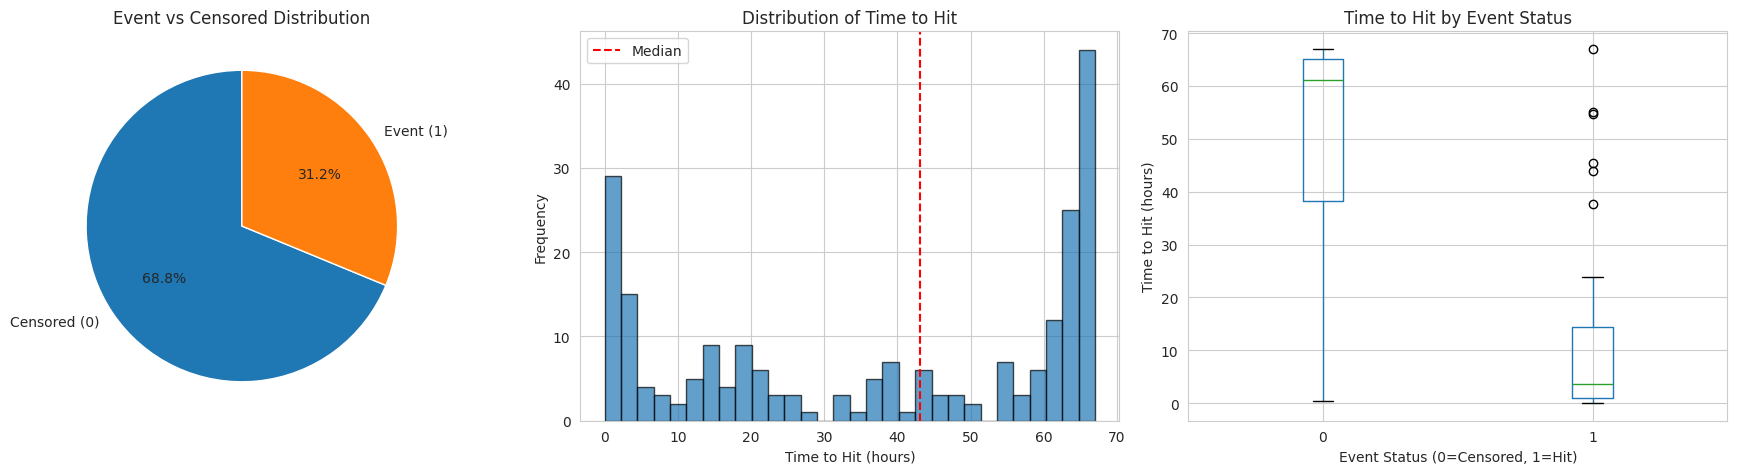


Events by Time Horizons:
  Fires hitting within 12h: 49 (22.2% of total)
  Fires hitting within 24h: 63 (28.5% of total)
  Fires hitting within 48h: 66 (29.9% of total)
  Fires hitting within 72h: 69 (31.2% of total)


In [ ]:
# Analyze target variables if present (only in train data)
if 'event' in train_df.columns and 'time_to_hit_hours' in train_df.columns:
    print("=" * 80)
    print("TARGET VARIABLE ANALYSIS")
    print("=" * 80)

    event_counts = train_df['event'].value_counts()
    print("\nEvent Distribution:")
    print(f"  Events (hit within 72h): {event_counts.get(1, 0)} ({event_counts.get(1, 0)/len(train_df)*100:.1f}%)")
    print(f"  Censored (no hit): {event_counts.get(0, 0)} ({event_counts.get(0, 0)/len(train_df)*100:.1f}%)")

    print("\nTime to Hit Statistics:")
    print(train_df['time_to_hit_hours'].describe())

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].pie(event_counts, labels=['Censored (0)', 'Event (1)'], autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Event vs Censored Distribution')

    axes[1].hist(train_df['time_to_hit_hours'], bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Time to Hit (hours)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Time to Hit')
    axes[1].axvline(train_df['time_to_hit_hours'].median(), color='red', linestyle='--', label='Median')
    axes[1].legend()

    train_df.boxplot(column='time_to_hit_hours', by='event', ax=axes[2])
    axes[2].set_xlabel('Event Status (0=Censored, 1=Hit)')
    axes[2].set_ylabel('Time to Hit (hours)')
    axes[2].set_title('Time to Hit by Event Status')
    plt.suptitle('')

    plt.tight_layout()
    plt.show()

    print("\nEvents by Time Horizons:")
    hits = train_df[train_df['event'] == 1]
    for horizon in [12, 24, 48, 72]:
        count = (hits['time_to_hit_hours'] <= horizon).sum()
        pct = count / len(train_df) * 100
        print(f"  Fires hitting within {horizon}h: {count} ({pct:.1f}% of total)")
else:
    print("Target variables not found - this appears to be test data")

## 4. Feature Overview and Categorization

In [ ]:
# Separate features by category
print("=" * 80)
print("FEATURE CATEGORIZATION")
print("=" * 80)

feature_categories = {
    'Identifier': ['event_id'],
    'Targets': ['event', 'time_to_hit_hours'],
    'Temporal Coverage': ['num_perimeters_0_5h', 'dt_first_last_0_5h', 'low_temporal_resolution_0_5h'],
    'Growth Features': [
        'area_first_ha', 'area_growth_abs_0_5h', 'area_growth_rel_0_5h',
        'area_growth_rate_ha_per_h', 'log1p_area_first', 'log1p_growth',
        'log_area_ratio_0_5h', 'relative_growth_0_5h', 'radial_growth_m',
        'radial_growth_rate_m_per_h'
    ],
    'Centroid Kinematics': [
        'centroid_displacement_m', 'centroid_speed_m_per_h', 'spread_bearing_deg',
        'spread_bearing_sin', 'spread_bearing_cos'
    ],
    'Distance to Evacuation': [
        'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h',
        'dist_slope_ci_0_5h', 'closing_speed_m_per_h', 'closing_speed_abs_m_per_h',
        'projected_advance_m', 'dist_accel_m_per_h2', 'dist_fit_r2_0_5h'
    ],
    'Directionality': [
        'alignment_cos', 'alignment_abs', 'cross_track_component', 'along_track_speed'
    ],
    'Temporal Metadata': [
        'event_start_hour', 'event_start_dayofweek', 'event_start_month'
    ]
}

for category, features in feature_categories.items():
    available_features = [f for f in features if f in train_df.columns]
    if available_features:
        print(f"\n{category}: {len(available_features)} features")
        for f in available_features:
            print(f"  - {f}")

FEATURE CATEGORIZATION

Identifier: 1 features
  - event_id

Targets: 2 features
  - event
  - time_to_hit_hours

Temporal Coverage: 3 features
  - num_perimeters_0_5h
  - dt_first_last_0_5h
  - low_temporal_resolution_0_5h

Growth Features: 10 features
  - area_first_ha
  - area_growth_abs_0_5h
  - area_growth_rel_0_5h
  - area_growth_rate_ha_per_h
  - log1p_area_first
  - log1p_growth
  - log_area_ratio_0_5h
  - relative_growth_0_5h
  - radial_growth_m
  - radial_growth_rate_m_per_h

Centroid Kinematics: 5 features
  - centroid_displacement_m
  - centroid_speed_m_per_h
  - spread_bearing_deg
  - spread_bearing_sin
  - spread_bearing_cos

Distance to Evacuation: 9 features
  - dist_min_ci_0_5h
  - dist_std_ci_0_5h
  - dist_change_ci_0_5h
  - dist_slope_ci_0_5h
  - closing_speed_m_per_h
  - closing_speed_abs_m_per_h
  - projected_advance_m
  - dist_accel_m_per_h2
  - dist_fit_r2_0_5h

Directionality: 4 features
  - alignment_cos
  - alignment_abs
  - cross_track_component
  - along_tra

## 5. Numerical Features Analysis

In [ ]:
exclude_cols = ['event_id', 'event', 'time_to_hit_hours']
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

print("=" * 80)
print("NUMERICAL FEATURES SUMMARY STATISTICS")
print("=" * 80)
print(f"\nTotal numerical features: {len(numerical_cols)}\n")

train_df[numerical_cols].describe().T

NUMERICAL FEATURES SUMMARY STATISTICS

Total numerical features: 34



,count,mean,std,min,25%,50%,75%,max
num_perimeters_0_5h,221.0,2.063348,2.578859,1.000000e+00,1.000000,1.000000,2.000000,17.000000
dt_first_last_0_5h,221.0,0.979869,1.738052,0.000000e+00,0.000000,0.000000,1.356107,4.994457
low_temporal_resolution_0_5h,221.0,0.728507,0.445739,0.000000e+00,0.000000,1.000000,1.000000,1.000000
area_first_ha,221.0,619.131641,1447.723668,3.752484e-02,25.219058,110.149250,485.092561,11942.392115
area_growth_abs_0_5h,221.0,26.332398,187.437018,-2.156175e-05,0.000000,0.000000,0.000000,2508.041442
area_growth_rel_0_5h,221.0,0.178909,1.302001,-1.437844e-07,0.000000,0.000000,0.000000,17.889695
area_growth_rate_ha_per_h,221.0,6.167128,40.467370,-5.292846e-06,0.000000,0.000000,0.000000,520.443033
log1p_area_first,221.0,4.683276,2.083529,3.683791e-02,3.266487,4.710874,6.186399,9.387933
log1p_growth,221.0,0.389346,1.340348,0.000000e+00,0.000000,0.000000,0.000000,7.827656
log_area_ratio_0_5h,221.0,0.065434,0.300321,-1.437844e-07,0.000000,0.000000,0.000000,2.938617


KEY FEATURE DISTRIBUTIONS


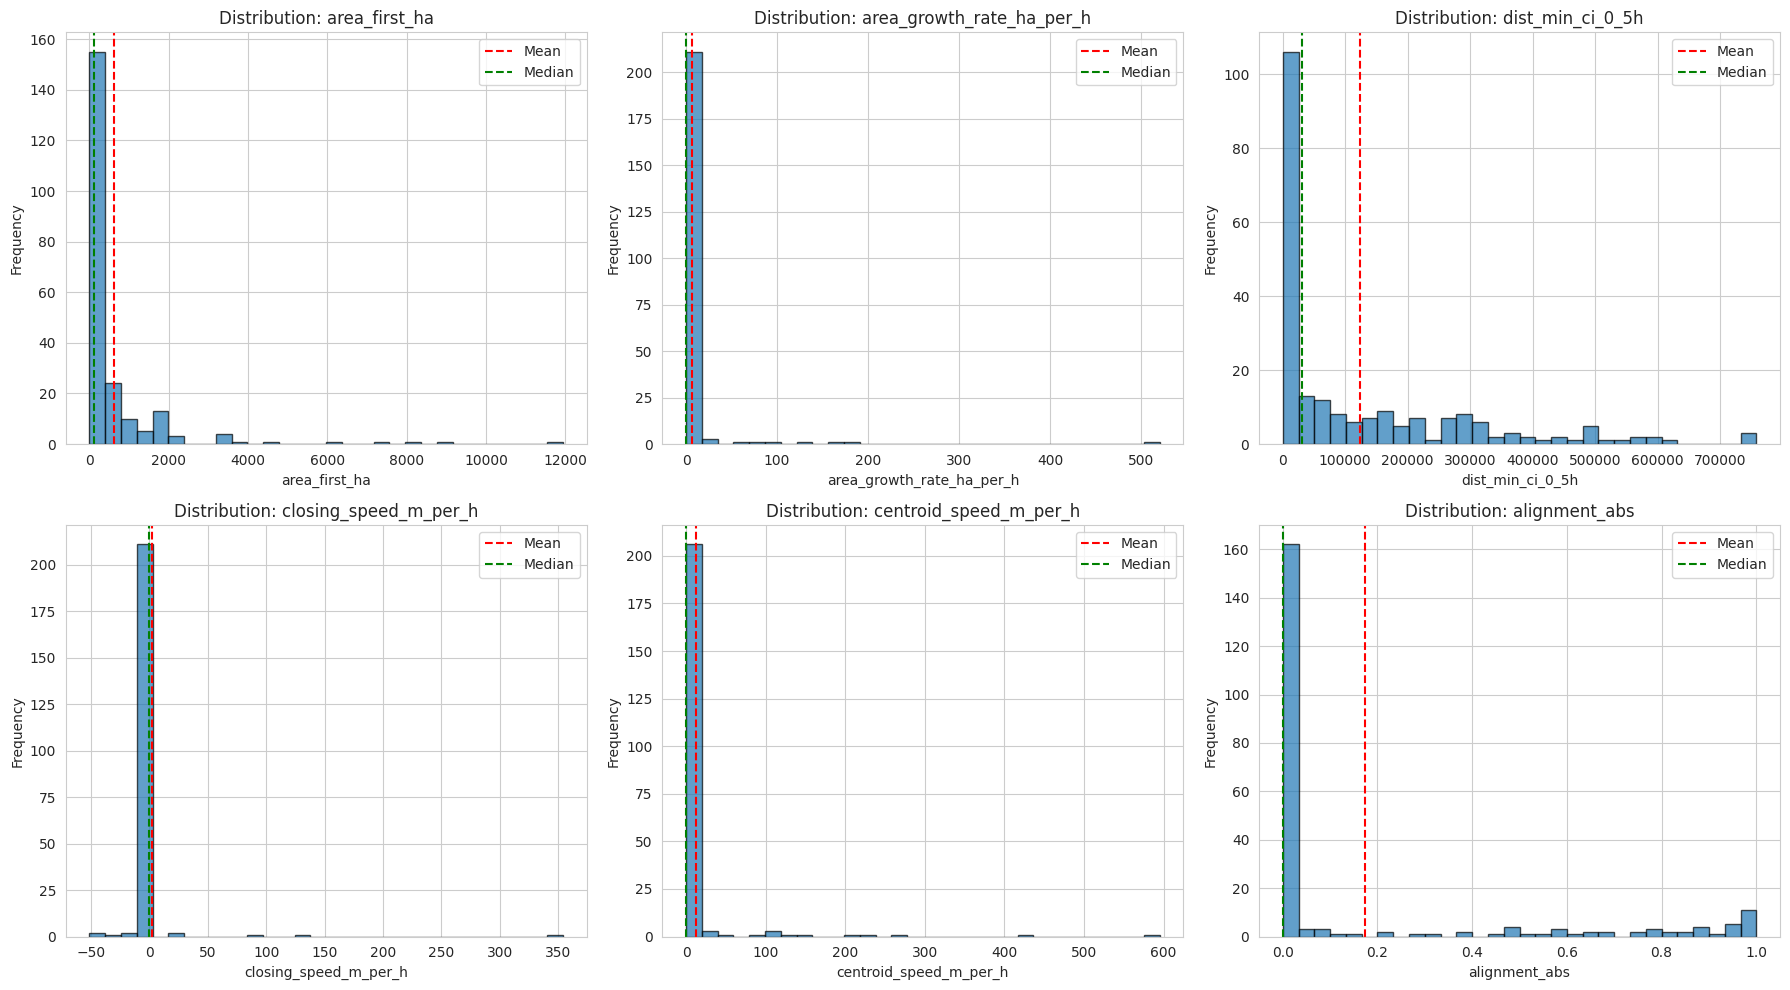

In [ ]:
# Distribution analysis for key features
print("=" * 80)
print("KEY FEATURE DISTRIBUTIONS")
print("=" * 80)

key_features = [
    'area_first_ha', 'area_growth_rate_ha_per_h', 'dist_min_ci_0_5h',
    'closing_speed_m_per_h', 'centroid_speed_m_per_h', 'alignment_abs'
]
key_features = [f for f in key_features if f in train_df.columns]

if key_features:
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for idx, feature in enumerate(key_features):
        axes[idx].hist(train_df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution: {feature}')

        axes[idx].axvline(train_df[feature].mean(), color='red', linestyle='--', label='Mean')
        axes[idx].axvline(train_df[feature].median(), color='green', linestyle='--', label='Median')
        axes[idx].legend()

    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Check for outliers using IQR method
print("=" * 80)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 80)

outlier_summary = []

for col in numerical_cols[:10]:  # Check first 10 features
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]

    if len(outliers) > 0:
        outlier_summary.append({
            'Feature': col,
            'Outlier_Count': len(outliers),
            'Outlier_Percentage': f"{len(outliers)/len(train_df)*100:.2f}%",
            'Lower_Bound': f"{lower_bound:.2f}",
            'Upper_Bound': f"{upper_bound:.2f}"
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print(outlier_df.to_string(index=False))
else:
    print("No significant outliers detected in the first 10 features.")

OUTLIER DETECTION (IQR Method)
                  Feature  Outlier_Count Outlier_Percentage Lower_Bound Upper_Bound
      num_perimeters_0_5h             29             13.12%       -0.50        3.50
       dt_first_last_0_5h             38             17.19%       -2.03        3.39
            area_first_ha             32             14.48%     -664.59     1174.90
     area_growth_abs_0_5h             25             11.31%        0.00        0.00
     area_growth_rel_0_5h             25             11.31%        0.00        0.00
area_growth_rate_ha_per_h             25             11.31%        0.00        0.00
             log1p_growth             24             10.86%        0.00        0.00
      log_area_ratio_0_5h             25             11.31%        0.00        0.00


## 6. Feature Correlations

FEATURE CORRELATIONS


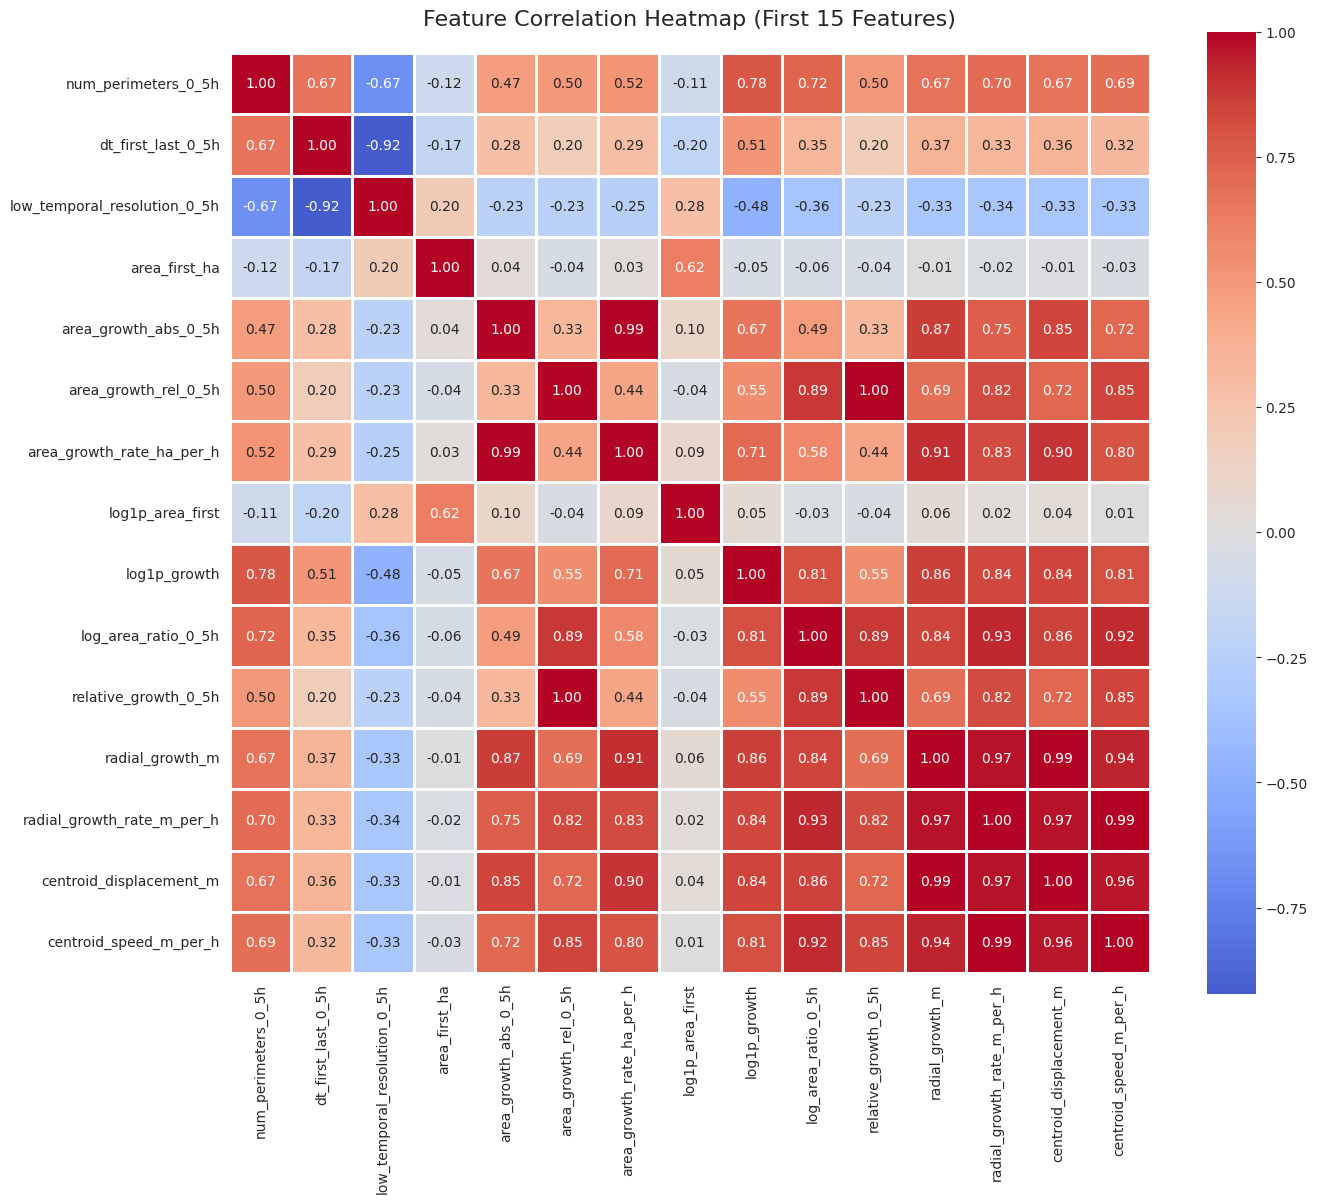


Highly Correlated Feature Pairs (|r| > 0.7):
                 Feature_1                    Feature_2 Correlation
       num_perimeters_0_5h                 log1p_growth       0.785
       num_perimeters_0_5h          log_area_ratio_0_5h       0.724
       num_perimeters_0_5h   radial_growth_rate_m_per_h       0.701
        dt_first_last_0_5h low_temporal_resolution_0_5h      -0.924
      area_growth_abs_0_5h    area_growth_rate_ha_per_h       0.991
      area_growth_abs_0_5h              radial_growth_m       0.867
      area_growth_abs_0_5h   radial_growth_rate_m_per_h       0.751
      area_growth_abs_0_5h      centroid_displacement_m       0.847
      area_growth_abs_0_5h       centroid_speed_m_per_h       0.715
      area_growth_rel_0_5h          log_area_ratio_0_5h       0.886
      area_growth_rel_0_5h         relative_growth_0_5h       1.000
      area_growth_rel_0_5h   radial_growth_rate_m_per_h       0.821
      area_growth_rel_0_5h      centroid_displacement_m       0.722
  

In [ ]:
# Correlation matrix for key features
print("=" * 80)
print("FEATURE CORRELATIONS")
print("=" * 80)

corr_features = numerical_cols[:15]
if len(corr_features) > 0:
    correlation_matrix = train_df[corr_features].corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1)
    plt.title('Feature Correlation Heatmap (First 15 Features)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature_1': correlation_matrix.columns[i],
                    'Feature_2': correlation_matrix.columns[j],
                    'Correlation': f"{correlation_matrix.iloc[i, j]:.3f}"
                })

    if high_corr:
        high_corr_df = pd.DataFrame(high_corr)
        print(high_corr_df.to_string(index=False))
    else:
        print("No highly correlated pairs found.")


CORRELATION WITH TARGET (EVENT)

Top 10 Features Positively Correlated with Event:
num_perimeters_0_5h           0.370501
dt_first_last_0_5h            0.352954
alignment_abs                 0.349115
log1p_growth                  0.292688
spread_bearing_deg            0.281012
log_area_ratio_0_5h           0.229327
radial_growth_rate_m_per_h    0.214956
radial_growth_m               0.209343
centroid_speed_m_per_h        0.209254
centroid_displacement_m       0.207992
Name: event, dtype: float64

Top 10 Features Negatively Correlated with Event:
cross_track_component          -0.058287
dist_accel_m_per_h2            -0.072594
dist_change_ci_0_5h            -0.106449
dist_slope_ci_0_5h             -0.115274
event_start_dayofweek          -0.119334
log1p_area_first               -0.167912
area_first_ha                  -0.181334
spread_bearing_cos             -0.323189
low_temporal_resolution_0_5h   -0.379117
dist_min_ci_0_5h               -0.481379
Name: event, dtype: float64


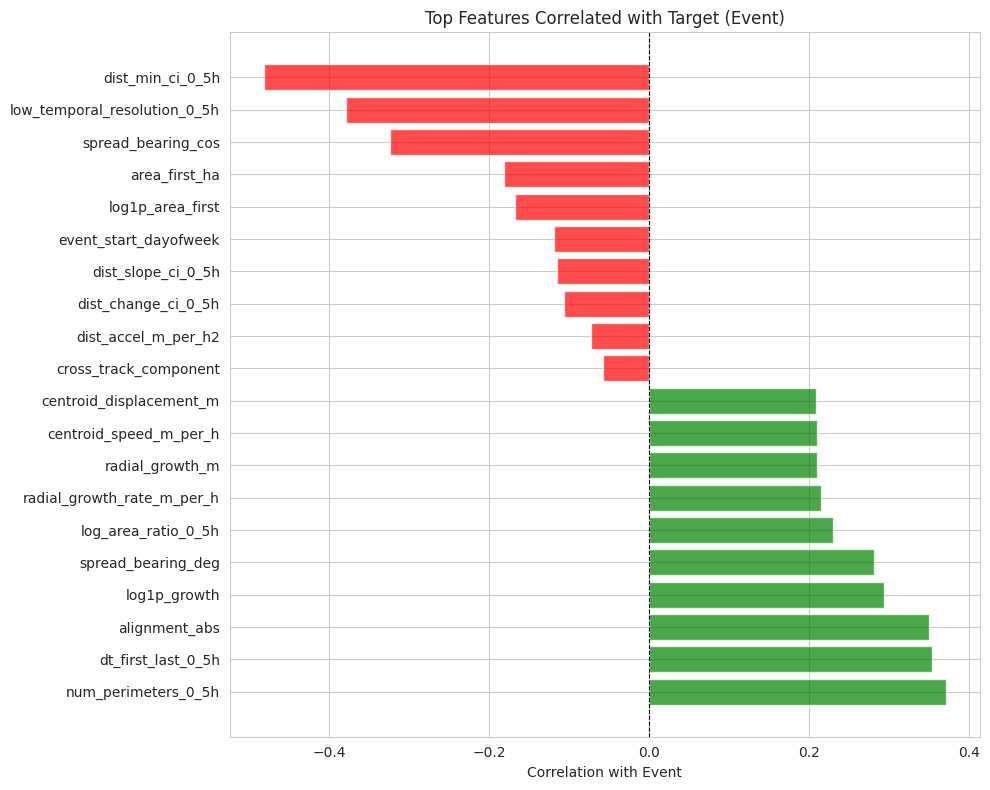

In [ ]:
# Correlation with target (if available)
if 'event' in train_df.columns:
    print("\n" + "=" * 80)
    print("CORRELATION WITH TARGET (EVENT)")
    print("=" * 80)

    target_corr = train_df[numerical_cols + ['event']].corr()['event'].sort_values(ascending=False)
    target_corr = target_corr.drop('event')  # Remove self-correlation

    print("\nTop 10 Features Positively Correlated with Event:")
    print(target_corr.head(10))

    print("\nTop 10 Features Negatively Correlated with Event:")
    print(target_corr.tail(10))

    # Visualize top correlations
    plt.figure(figsize=(10, 8))
    top_features = pd.concat([target_corr.head(10), target_corr.tail(10)])
    colors = ['green' if x > 0 else 'red' for x in top_features.values]
    plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Correlation with Event')
    plt.title('Top Features Correlated with Target (Event)')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

## 7. Categorical Features Analysis

TEMPORAL METADATA ANALYSIS


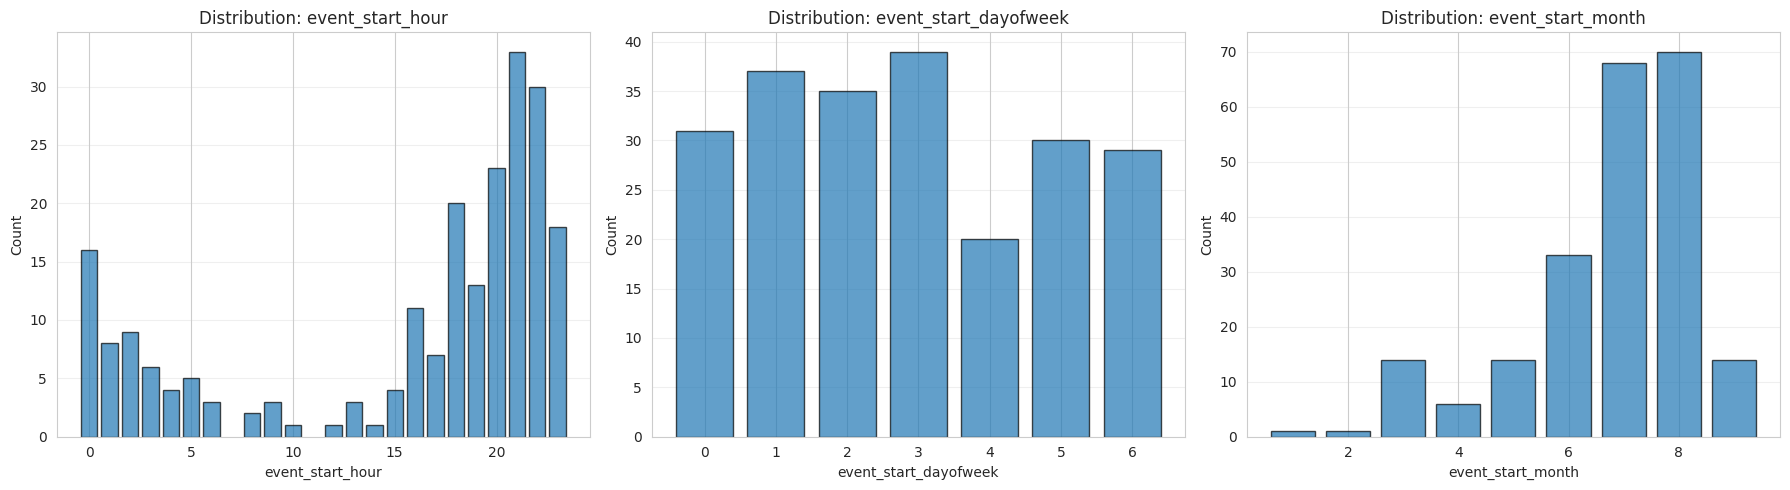


event_start_hour:
event_start_hour
0     16
1      8
2      9
3      6
4      4
5      5
6      3
8      2
9      3
10     1
12     1
13     3
14     1
15     4
16    11
17     7
18    20
19    13
20    23
21    33
22    30
23    18
Name: count, dtype: int64

event_start_dayofweek:
event_start_dayofweek
0    31
1    37
2    35
3    39
4    20
5    30
6    29
Name: count, dtype: int64

event_start_month:
event_start_month
1     1
2     1
3    14
4     6
5    14
6    33
7    68
8    70
9    14
Name: count, dtype: int64


In [ ]:
# Analyze temporal metadata (categorical-like features)
print("=" * 80)
print("TEMPORAL METADATA ANALYSIS")
print("=" * 80)

temporal_features = ['event_start_hour', 'event_start_dayofweek', 'event_start_month']
temporal_features = [f for f in temporal_features if f in train_df.columns]

if temporal_features:
    fig, axes = plt.subplots(1, len(temporal_features), figsize=(6*len(temporal_features), 5))
    if len(temporal_features) == 1:
        axes = [axes]

    for idx, feature in enumerate(temporal_features):
        value_counts = train_df[feature].value_counts().sort_index()
        axes[idx].bar(value_counts.index, value_counts.values, alpha=0.7, edgecolor='black')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'Distribution: {feature}')
        axes[idx].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    for feature in temporal_features:
        print(f"\n{feature}:")
        print(train_df[feature].value_counts().sort_index())

## 8. Data Quality Summary Report

In [ ]:
print("=" * 80)
print("DATA QUALITY SUMMARY REPORT")
print("=" * 80)

print(f"\nDataset Overview:")
print(f"  Total samples: {len(train_df)}")
print(f"  Total features: {len(train_df.columns)}")
print(f"  Numerical features: {len(numerical_cols)}")

if 'event' in train_df.columns:
    print(f"\nTarget Distribution:")
    event_counts = train_df['event'].value_counts()
    print(f"  Events (1): {event_counts.get(1, 0)} ({event_counts.get(1, 0)/len(train_df)*100:.1f}%)")
    print(f"  Censored (0): {event_counts.get(0, 0)} ({event_counts.get(0, 0)/len(train_df)*100:.1f}%)")

print(f"\nData Quality:")
missing_cols = train_df.isnull().sum().sum()
print(f"  Missing values: {missing_cols} {'(None! ✓)' if missing_cols == 0 else ''}")
print(f"  Duplicate rows: {train_df.duplicated().sum()} {'(None! ✓)' if train_df.duplicated().sum() == 0 else ''}")

DATA QUALITY SUMMARY REPORT

Dataset Overview:
  Total samples: 221
  Total features: 37
  Numerical features: 34

Target Distribution:
  Events (1): 69 (31.2%)
  Censored (0): 152 (68.8%)

Data Quality:
  Missing values: 0 (None! ✓)
  Duplicate rows: 0 (None! ✓)
